# Introduction
Manual for the preparation and use of the Deep Learning model for battery SoH prediction
This Python Notebook shows and analyzes how the battery charge / discharge dataset obtained from NASA should be treated. It also shows how the model proposed by [1] and [2] is prepared and its encoding necessary to be used.

Requirements
For the training phase of this model it is necessary to have Python 3.x installed along with the following libraries:

Tensorflow 2.0
Numpy
Pandas
Scipy
Sci-kit learn
Matplot
Seaborn
For the prediction phase of this model it is necessary to have the same libraries with the exception of Matplot and Seaborn

Dataset preparation
Since this manual was created from Google Colab (this may not be necessary to do it in an offline environment), it is necessary to download the dataset and then unzip it in a specific directory.

In [ ]:
%config Completer.use_jedi = False


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  """Entry point for launching an IPython kernel.


In [ ]:
%matplotlib inline
!pip show tensorflow
!pip install spectrum
!pip install statsmodels --upgrade
!wget -cq https://ti.arc.nasa.gov/c/5 -O naza.zip
!unzip -qqo naza.zip -d battery_data

Name: tensorflow
Version: 2.7.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: google-pasta, typing-extensions, grpcio, gast, flatbuffers, tensorboard, h5py, tensorflow-estimator, six, libclang, tensorflow-io-gcs-filesystem, wheel, opt-einsum, termcolor, protobuf, keras-preprocessing, wrapt, astunparse, absl-py, keras, numpy
Required-by: kapre
     |████████████████████████████████| 228 kB 7.2 MB/s 
  Created wheel for spectrum: filename=spectrum-0.8.0-cp37-cp37m-linux_x86_64.whl size=234831 sha256=0598358e4c8ff4bb15723fef62ac47951329bfe52e8d701c5d1676ffe64bd09c
  Stored in directory: /root/.cache/pip/wheels/ac/a0/2b/aba9ac3cce046bc454a44d0db5b711b4e927a0dd33a93e9d98
Successfully built spectrum
     |████████████████████████████████| 9.8 MB 7.4 MB/s 
  Attempting uninstall: statsmo

# Library import
In this part, all the necessary libraries for the treatment of the dataset are important.

In [ ]:
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from spectrum import *

# Loading the dataset into memory
According to the README of the dataset, the data is stored in several ".mat" files, each file corresponds to a specific battery and the data structure of each file is as follows:

```
Data Structure:
cycle:	top level structure array containing the charge, discharge and impedance operations
	type: 	operation  type, can be charge, discharge or impedance
	ambient_temperature:	ambient temperature (degree C)
	time: 	the date and time of the start of the cycle, in MATLAB  date vector format
	data:	data structure containing the measurements
	   for charge the fields are:
		Voltage_measured: 	Battery terminal voltage (Volts)
		Current_measured:	Battery output current (Amps)
		Temperature_measured: 	Battery temperature (degree C)
		Current_charge:		Current measured at charger (Amps)
		Voltage_charge:		Voltage measured at charger (Volts)
		Time:			Time vector for the cycle (secs)
	   for discharge the fields are:
		Voltage_measured: 	Battery terminal voltage (Volts)
		Current_measured:	Battery output current (Amps)
		Temperature_measured: 	Battery temperature (degree C)
		Current_charge:		Current measured at load (Amps)
		Voltage_charge:		Voltage measured at load (Volts)
		Time:			Time vector for the cycle (secs)
		Capacity:		Battery capacity (Ahr) for discharge till 2.7V 
	   for impedance the fields are:
		Sense_current:		Current in sense branch (Amps)
		Battery_current:	Current in battery branch (Amps)
		Current_ratio:		Ratio of the above currents 
		Battery_impedance:	Battery impedance (Ohms) computed from raw data
		Rectified_impedance:	Calibrated and smoothed battery impedance (Ohms) 
		Re:			Estimated electrolyte resistance (Ohms)
		Rct:			Estimated charge transfer resistance (Ohms)

```

For the Deep Learning model proposed in [1] it is only necessary to collect the data related to the discharge of the battery, for this a function is created in Python that is in charge of reading this data from the ".mat" file and storing it in memory in two pandas DataFrame for later access. After loading the dataset, a description of the data is made using panda functions to verify if the data loading was correct.

In [ ]:
def load_data(battery):
  mat = loadmat('battery_data/' + battery + '.mat')
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]
dataset, capacity = load_data('B0005')
pd.set_option('display.max_columns', 10)
print(dataset.head())
dataset.describe()

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.856487          4.191492   
1      1                   24 2008-04-02 15:25:41  1.856487          4.190749   
2      1                   24 2008-04-02 15:25:41  1.856487          3.974871   
3      1                   24 2008-04-02 15:25:41  1.856487          3.951717   
4      1                   24 2008-04-02 15:25:41  1.856487          3.934352   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.004902             24.330034       -0.0006         0.000   0.000  
1         -0.001478             24.325993       -0.0006         4.206  16.781  
2         -2.012528             24.389085       -1.9982         3.062  35.703  
3         -2.

,cycle,ambient_temperature,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
count,50285.000000,50285.0,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000
mean,88.125942,24.0,1.560345,3.515268,-1.806032,32.816991,1.362700,2.308406,1546.208924
std,45.699687,0.0,0.182380,0.231778,0.610502,3.987515,1.313698,0.800300,906.640295
min,1.000000,24.0,1.287453,2.455679,-2.029098,23.214802,-1.998400,0.000000,0.000000
25%,50.000000,24.0,1.386229,3.399384,-2.013415,30.019392,1.998000,2.388000,768.563000
50%,88.000000,24.0,1.538237,3.511664,-2.012312,32.828944,1.998200,2.533000,1537.031000
75%,127.000000,24.0,1.746871,3.660903,-2.011052,35.920887,1.998200,2.690000,2305.984000
max,168.000000,24.0,1.856487,4.222920,0.007496,41.450232,1.998400,4.238000,3690.234000


In [ ]:
new_df= dataset.groupby('capacity').mean()
new_df= new_df.sort_values(by=['cycle']).reset_index()
new_df= new_df.drop('ambient_temperature',axis=1)

In [ ]:
time_df= dataset.groupby('capacity').max()
time_df= time_df.sort_values(by=['cycle']).reset_index()
time_df

,capacity,cycle,ambient_temperature,datetime,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
0,1.856487,1,24,2008-04-02 15:25:41,4.191492,0.000729,38.982181,-0.0004,4.206,3690.234
1,1.846327,2,24,2008-04-02 19:43:48,4.189773,0.002927,39.033398,-0.0006,4.204,3672.344
2,1.835349,3,24,2008-04-03 00:01:06,4.188187,0.001484,38.818797,-0.0004,4.203,3651.641
3,1.835263,4,24,2008-04-03 04:16:37,4.188461,0.001547,38.762305,-0.0006,4.203,3631.563
4,1.834646,5,24,2008-04-03 08:33:25,4.188299,0.001701,38.665393,-0.0006,4.203,3629.172
...,...,...,...,...,...,...,...,...,...,...
163,1.293464,164,24,2008-05-26 10:44:38,4.196641,0.001665,40.983663,1.9982,4.211,2793.390
164,1.288003,165,24,2008-05-26 15:30:43,4.195624,0.002688,40.982342,1.9982,4.211,2793.390
165,1.287453,166,24,2008-05-26 20:21:04,4.195862,0.002692,41.063751,1.9982,4.211,2792.485
166,1.309015,167,24,2008-05-27 15:52:41,4.184827,0.001336,41.047030,1.9982,4.200,2802.016


In [ ]:
new_df['time']= time_df['time']
new_df

,capacity,cycle,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
0,1.856487,1,3.529829,-1.818702,32.572328,-1.805570,2.404944,3690.234
1,1.846327,2,3.537320,-1.817560,32.725235,-1.804583,2.399260,3672.344
2,1.835349,3,3.543737,-1.816487,32.642862,-1.803575,2.397969,3651.641
3,1.835263,4,3.543666,-1.825589,32.514876,-1.812863,2.408289,3631.563
4,1.834646,5,3.542343,-1.826114,32.382349,-1.812876,2.408505,3629.172
...,...,...,...,...,...,...,...,...
163,1.293464,164,3.466462,-1.674488,33.275688,1.661799,2.073168,2793.390
164,1.288003,165,3.468509,-1.667447,33.320678,1.655086,2.064189,2793.390
165,1.287453,166,3.466806,-1.667470,33.373150,1.655103,2.062717,2792.485
166,1.309015,167,3.471071,-1.688898,33.713519,1.676430,2.107460,2802.016


In [ ]:
dataset_1 = dataset[dataset['cycle']==1]
dataset_1.shape

(197, 10)

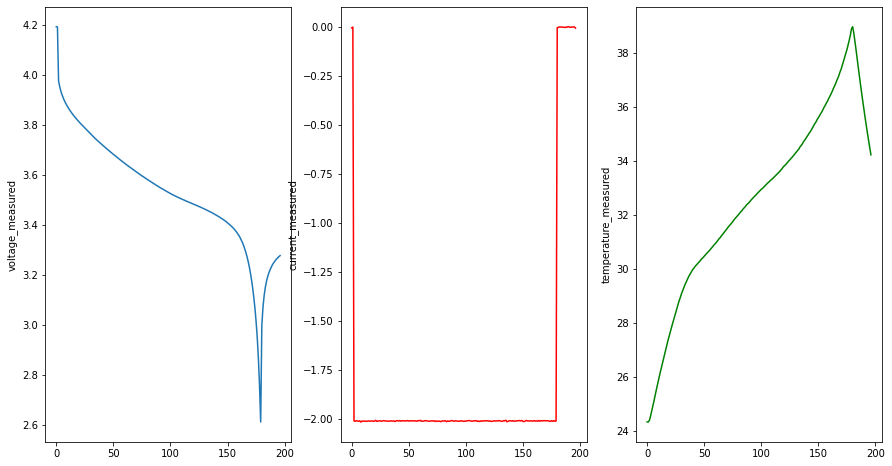

In [ ]:
plt.figure(figsize=(15,8))
ax1 = plt.subplot(1,3,1)
sns.lineplot(data=dataset_1, x=dataset_1.index, y=dataset_1['voltage_measured'])
ax2 = plt.subplot(1,3,2)
sns.lineplot(data=dataset_1, x=dataset_1.index, y=dataset_1['current_measured'], color='red')
ax3 = plt.subplot(1,3,3)
sns.lineplot(data=dataset_1, x=dataset_1.index, y=dataset_1['temperature_measured'], color='green')


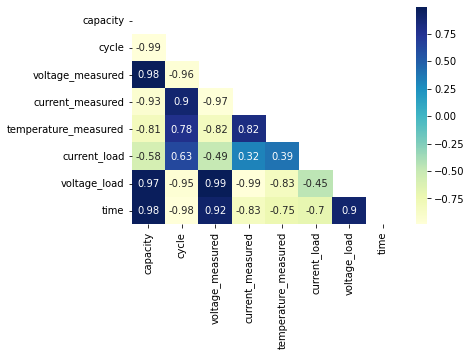

In [ ]:
mask = np.triu(np.ones_like(new_df.corr(), dtype=bool))
dataplot = sns.heatmap(new_df.corr(), cmap="YlGnBu",mask=mask, annot=True)

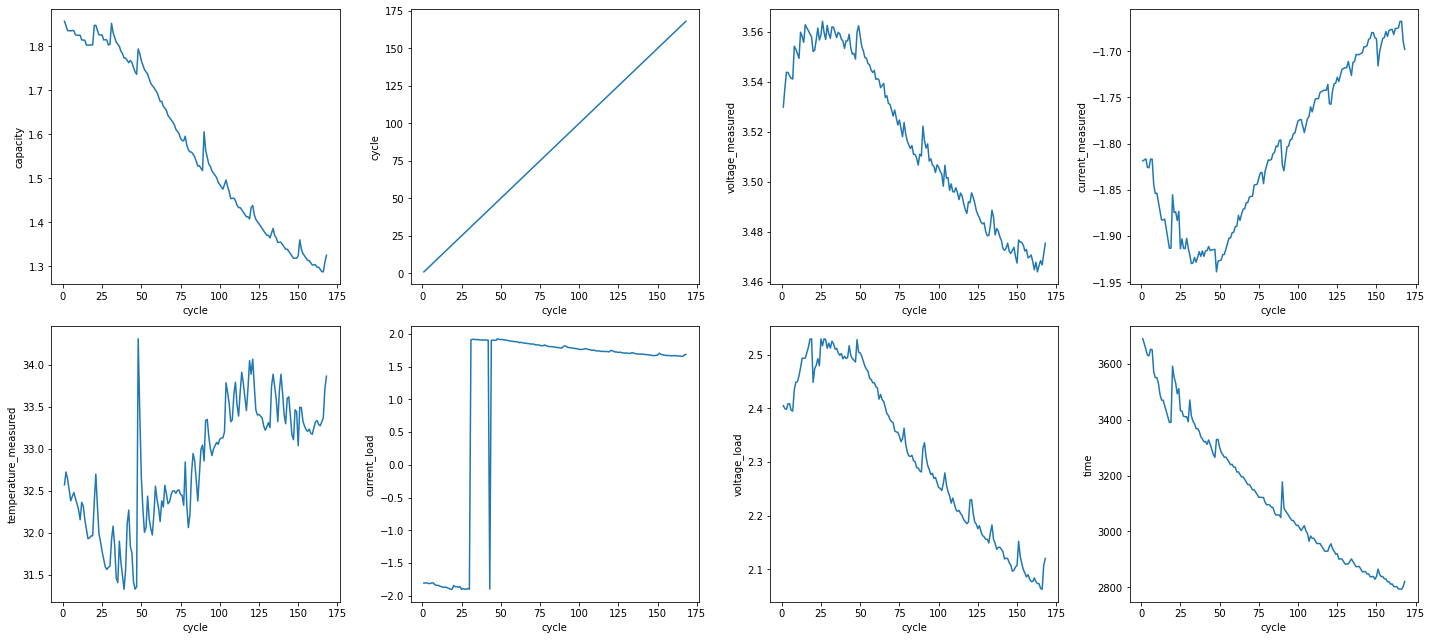

In [ ]:
plt.figure(figsize=(20, 9))
i=0
column= new_df.columns
for row in range(2):
    for col in range(4):
        plt.subplot(2,4,i+1)
        plt.plot(new_df['cycle'],new_df[column[i]])
        plt.xlabel('cycle')
        plt.ylabel(column[i])
        i+=1
plt.tight_layout()

The following graph shows the aging process of the battery as the charge cycles progress. The horizontal line represents the threshold related to what can be considered the end of the battery's life cycle.

In [ ]:
capacity.head()

,cycle,ambient_temperature,datetime,capacity
0,1,24,2008-04-02 15:25:41,1.856487
1,2,24,2008-04-02 19:43:48,1.846327
2,3,24,2008-04-03 00:01:06,1.835349
3,4,24,2008-04-03 04:16:37,1.835263
4,5,24,2008-04-03 08:33:25,1.834646


Text(0.5, 1.0, 'Discharge B0005')

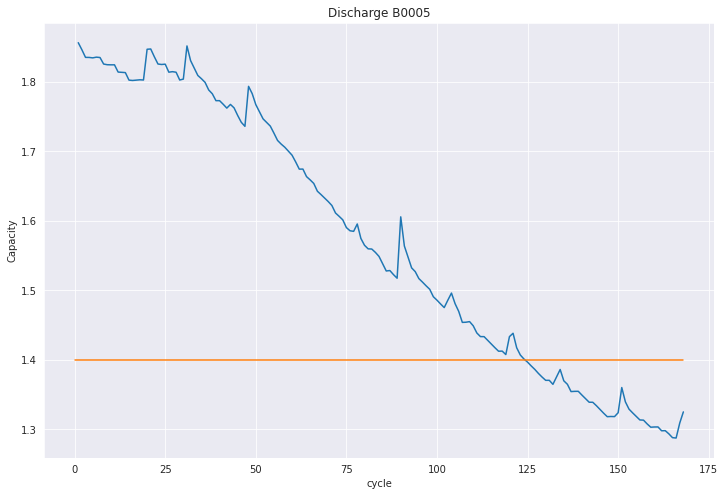

In [ ]:
plot_df = capacity.loc[(capacity['cycle']>=1),['cycle','capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.plot(plot_df['cycle'], plot_df['capacity'])
#Draw threshold
plt.plot([0.,len(capacity)], [1.4, 1.4])
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

It is also necessary to calculate the SoH of the battery, since this is the data that will be predicted using the * deep learning * model.

In [ ]:
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity'])/C
print(dis_ele.head(5))

   cycle            datetime  capacity       SoH
0      1 2008-04-02 15:25:41  1.856487  1.000000
1      2 2008-04-02 19:43:48  1.846327  0.994527
2      3 2008-04-03 00:01:06  1.835349  0.988614
3      4 2008-04-03 04:16:37  1.835263  0.988567
4      5 2008-04-03 08:33:25  1.834646  0.988235


Similarly to what has been done previously, a graph of the SoH is made for each cycle, the horizontal line represents the threshold of 70% in which the battery already fulfills its life cycle and it is advisable to make the change.

Text(0.5, 1.0, 'Discharge B0005')

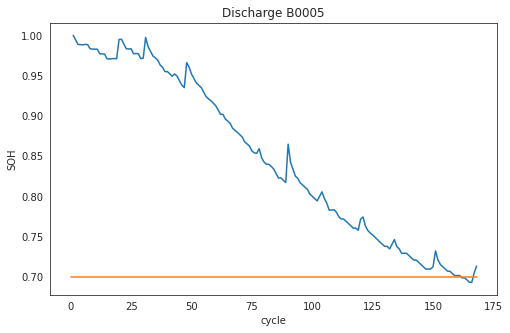

In [ ]:
plot_df = dis_ele.loc[(dis_ele['cycle']>=1),['cycle','SoH']]
sns.set_style("white")
plt.figure(figsize=(8, 5))
plt.plot(plot_df['cycle'], plot_df['SoH'])
#Draw threshold
plt.plot([0.,len(capacity)], [0.70, 0.70])
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

# Training phase for calculating SoH
The dataset is prepared in such a way that it can be used by Tensorflow in the training phase, for this, two structures are created corresponding to the input and output expected to be obtained. For the input data, the relevant characteristics of the dataset are filtered, which are:


* Voltage
* Current
* Temperature
* Charging voltage
* Charging current
* Instant of time (from the start of the download)

For the output data, We use Battery capacity as the value

In [ ]:
C = dataset['capacity'][0]
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

attribs=['voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
print(train_dataset.shape)
print(soh.shape)

(50285, 6)
(50285, 1)


In [ ]:
dataset.head()

,cycle,ambient_temperature,datetime,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
0,1,24,2008-04-02 15:25:41,1.856487,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000
1,1,24,2008-04-02 15:25:41,1.856487,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781
2,1,24,2008-04-02 15:25:41,1.856487,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703
3,1,24,2008-04-02 15:25:41,1.856487,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781
4,1,24,2008-04-02 15:25:41,1.856487,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922


In [ ]:
dataset.shape

(50285, 10)

Preparation of the model, 3 dense layers are used, and the parameters are used as they are in the paper: 3 dense layers and one dropout, and one of the ADAM type is used as optimizer

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential()
model.add(Dense(8, activation='relu', input_dim=train_dataset.shape[1]))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(1))
model.summary()
model.compile(optimizer=Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss='mean_absolute_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 56        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 209
Trainable params: 209
Non-trainable params: 0
_________________________________________________________________


## The model is trained, 50 epochs are used for training

In [ ]:
model.fit(x=train_dataset, y=dataset['capacity'].to_numpy(), batch_size=25, epochs=50)

Epoch 1/50
2012/2012 [==============================] - 3s 1ms/step - loss: 0.2726
Epoch 2/50
2012/2012 [==============================] - 3s 1ms/step - loss: 0.0950
Epoch 3/50
2012/2012 [==============================] - 3s 1ms/step - loss: 0.0672
Epoch 4/50
2012/2012 [==============================] - 3s 1ms/step - loss: 0.0617
Epoch 5/50
2012/2012 [==============================] - 3s 1ms/step - loss: 0.0600
Epoch 6/50
2012/2012 [==============================] - 3s 1ms/step - loss: 0.0594
Epoch 7/50
2012/2012 [==============================] - 3s 1ms/step - loss: 0.0595
Epoch 8/50
2012/2012 [==============================] - 3s 1ms/step - loss: 0.0585
Epoch 9/50
2012/2012 [==============================] - 3s 1ms/step - loss: 0.0591
Epoch 10/50
2012/2012 [==============================] - 3s 1ms/step - loss: 0.0583
Epoch 11/50
2012/2012 [==============================] - 3s 1ms/step - loss: 0.0581
Epoch 12/50
2012/2012 [==============================] - 3s 1ms/step - loss: 0.0585
E

# Testing to test the SoH prediction model
To test the correctness of the model, the information of the same battery is loaded (B0006)

In [ ]:
dataset_val, capacity_val = load_data('B0006')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
print(dataset_val.head(5))
#print(dis_ele.head(5))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 2.035337591005598, 4.179799607333447, -0.0023663271409738672, 24.277567510331888, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  2.035338          4.179800   
1      1                   24 2008-04-02 15:25:41  2.035338          4.179823   
2      1                   24 2008-04-02 15:25:41  2.035338          3.966528   
3      1                   24 2008-04-02 15:25:41  2.035338          3.945886   
4      1                   24 2008-04-02 15:25:41  2.035338          3.930354   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.002366             24.277568       -0.0006         0.000   0.000  
1          0.000434             24.277073       -0.0006         4.195  16.781  
2         -2.014242             24.366226       -1.9990         3.070  35.703  
3         -2.

A table is created containing the real SoH and the SoH predicted by the network and the root of the mean square error is calculated.

In [ ]:
attrib=[ 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time']
capacity_pred = model.predict(sc.fit_transform(dataset_val[attrib]))
print(capacity_pred.shape)

C = dataset_val['capacity'][0]
soh = []
for i in range(len(dataset_val)):
  soh.append(dataset_val['capacity'][i] / C)
new_capacity = dataset_val.loc[(dataset_val['cycle'] >= 1), ['cycle']]
new_capacity['Capacity'] = dataset_val['capacity']
new_capacity['predCap'] = capacity_pred
new_capacity = new_capacity.groupby(['cycle']).mean().reset_index()
print(new_capacity.head(10))
rms = np.sqrt(mean_squared_error(new_capacity['Capacity'], new_capacity['predCap']))
print('Root Mean Square Error: ', rms)

(50285, 1)
   cycle  Capacity   predCap
0      1  2.035338  1.811734
1      2  2.025140  1.813102
2      3  2.013326  1.813006
3      4  2.013285  1.812172
4      5  2.000528  1.811372
5      6  2.013899  1.813892
6      7  2.013101  1.814143
7      8  1.968790  1.809847
8      9  1.968166  1.808748
9     10  1.957231  1.808082
Root Mean Square Error:  0.08999200990664216


Finally both Capacity are plotted to observe their differences

Text(0.5, 1.0, 'Discharge B0006')

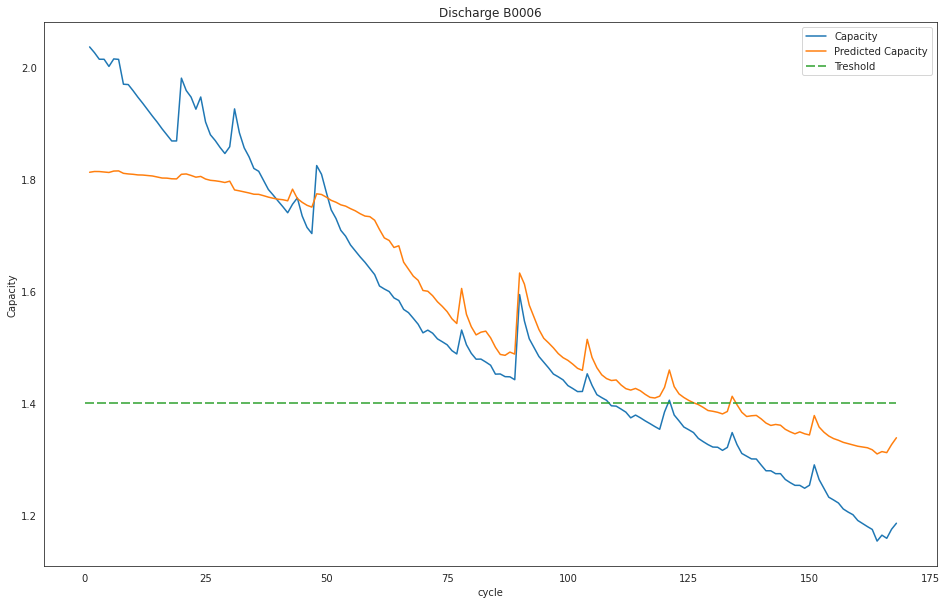

In [ ]:
plot_df = new_capacity.loc[(new_capacity['cycle']>=1),['cycle','Capacity', 'predCap']]
sns.set_style("white")
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['Capacity'], label='Capacity')
plt.plot(plot_df['cycle'], plot_df['predCap'], label='Predicted Capacity')
#Draw threshold
#plt.plot([0.,len(capacity)], [0.70, 0.70], label='Threshold')
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.plot([0.,168], [1.4, 1.4],dashes=[6, 2], label="Treshold")
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0006')

For the estimation of SoH, it can be seen that the data pattern is learned by the model correctly, as predicted by the theory, since the shape of the curves is almost identical. The SoH shown has the same behavior as expected in theory, which is corroborated with the root mean square error value of the graph in illustration 8, whose value of 9% is very similar to that found previously. This reaffirms the precision when making the prediction.

Since B0006 and B0005 have difference in initial capacity, our model predictions at the first few cycle quite off but it could still get the trends of degradtion and get the end of life prediction really close to the true value
 

# Capacity Predicition for B0005 by training first 40 cycle


## Prepare data

In [ ]:
attribs=['voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load']
train_cycle = dataset[(dataset['cycle']<=40)]['cycle'].reset_index().drop('index',axis=1)
test_cycle =  dataset[(dataset['cycle']>40)]['cycle'].reset_index().drop('index',axis=1)
train_dataset = dataset.loc[(dataset['cycle']<=40),attribs]
test_dataset = dataset.loc[(dataset['cycle']>40),attribs]
train_target_value = dataset.loc[(dataset['cycle']<=40),'capacity']
test_target_value = dataset.loc[(dataset['cycle']>40),'capacity']
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
test_dataset = sc.transform(test_dataset)
rms_table={}
print(f'Shape of train dataset: {train_dataset.shape}')
print(f'Shape of target value of dataset: {train_target_value.shape}')


Shape of train dataset: (9254, 5)
Shape of target value of dataset: (9254,)


## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(train_dataset, train_target_value)
pred = reg.predict(test_dataset)

In [ ]:
true_value = np.array(test_target_value).reshape(-1,1)
predict_value = pred.reshape(-1, 1)
print(true_value.shape)
print(predict_value.shape)
check_arr = np.concatenate([true_value, predict_value,test_cycle], axis=1)
test_df = pd.DataFrame(check_arr)
test_df.columns =['True Value','Predict Value', 'cycle']
test_df = test_df.groupby(['cycle']).mean().reset_index()
test_df=test_df.set_index('cycle')
print(test_df.head())
rms = np.sqrt(mean_squared_error(test_df['True Value'], test_df['Predict Value']))
print('Root Mean Square Error: ', np.round(rms,5))
rms_table['Linear Regression'] = rms

(41031, 1)
(41031, 1)
       True Value  Predict Value
cycle                           
41.0     1.767872       1.805606
42.0     1.762315       1.806063
43.0     1.767617       1.822225
44.0     1.762668       1.804510
45.0     1.751730       1.803457
Root Mean Square Error:  0.34587


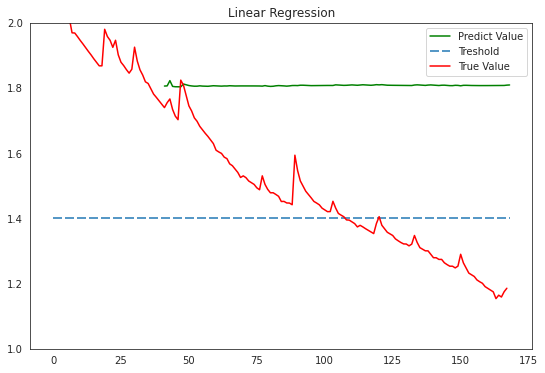

In [ ]:
# Plot the prediction vs test data
from matplotlib import pyplot
pyplot.figure(figsize=(9, 6))
pyplot.plot(test_df['Predict Value'], label="Predict Value", color='Green')
pyplot.plot([0.,168], [1.4, 1.4],dashes=[6, 2], label="Treshold")
pyplot.plot(plot_df['Capacity'], color='red', label="True Value")
plt.ylim(1, 2)
plt.title('Linear Regression')
plt.legend()

## K Nearest **Neighbor**

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
reg = KNeighborsRegressor().fit(train_dataset, train_target_value)
pred = reg.predict(test_dataset)

In [ ]:
true_value = np.array(test_target_value).reshape(-1,1)
predict_value = pred.reshape(-1, 1)
print(true_value.shape)
print(predict_value.shape)
check_arr = np.concatenate([true_value, predict_value,test_cycle], axis=1)
test_df = pd.DataFrame(check_arr)
test_df.columns =['True Value','Predict Value', 'cycle']
test_df = test_df.groupby(['cycle']).mean().reset_index()
test_df=test_df.set_index('cycle')
print(test_df.tail())
rms = np.sqrt(mean_squared_error(test_df['True Value'], test_df['Predict Value']))
print('Root Mean Square Error: ', np.round(rms,5))
rms_table['K Nearest Neighbor'] = rms

(41031, 1)
(41031, 1)
       True Value  Predict Value
cycle                           
164.0    1.293464       1.789812
165.0    1.288003       1.790075
166.0    1.287453       1.790444
167.0    1.309015       1.794661
168.0    1.325079       1.802449
Root Mean Square Error:  0.33717


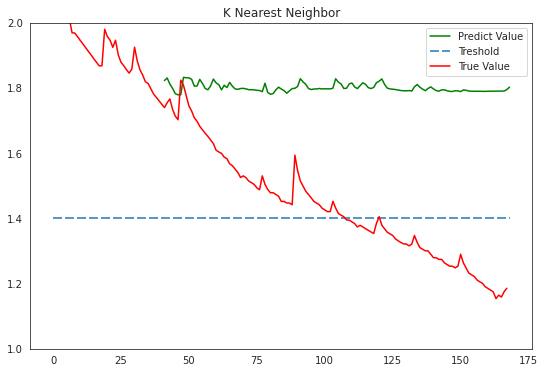

In [ ]:
# Plot the prediction vs test data
from matplotlib import pyplot
pyplot.figure(figsize=(9, 6))
pyplot.plot(test_df['Predict Value'], label="Predict Value", color='Green')
pyplot.plot([0.,168], [1.4, 1.4],dashes=[6, 2], label="Treshold")
pyplot.plot(plot_df['Capacity'], color='red', label="True Value")
plt.title('K Nearest Neighbor')
plt.ylim(1, 2)
plt.legend()

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor().fit(train_dataset, train_target_value)
pred = reg.predict(test_dataset)

In [ ]:
true_value = np.array(test_target_value).reshape(-1,1)
predict_value = pred.reshape(-1, 1)
print(true_value.shape)
print(predict_value.shape)
check_arr = np.concatenate([true_value, predict_value,test_cycle], axis=1)
test_df = pd.DataFrame(check_arr)
test_df.columns =['True Value','Predict Value', 'cycle']
test_df = test_df.groupby(['cycle']).mean().reset_index()
test_df=test_df.set_index('cycle')
print(test_df.tail())
rms = np.sqrt(mean_squared_error(test_df['True Value'], test_df['Predict Value']))
print('Root Mean Square Error: ',np.round(rms,5))
rms_table['Decision Tree'] = rms

(41031, 1)
(41031, 1)
       True Value  Predict Value
cycle                           
164.0    1.293464       1.785152
165.0    1.288003       1.784983
166.0    1.287453       1.785597
167.0    1.309015       1.789562
168.0    1.325079       1.799134
Root Mean Square Error:  0.33217


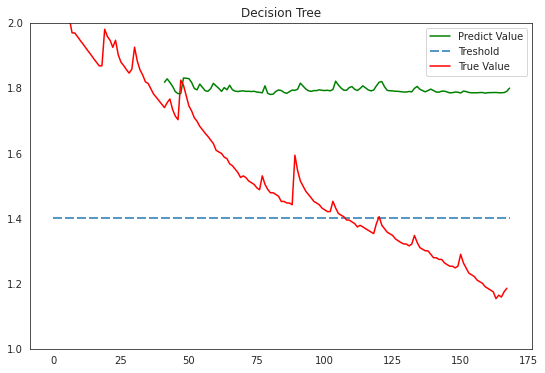

In [ ]:
# Plot the prediction vs test data
from matplotlib import pyplot
pyplot.figure(figsize=(9, 6))
pyplot.plot(test_df['Predict Value'], label="Predict Value", color='Green')
pyplot.plot([0.,168], [1.4, 1.4],dashes=[6, 2], label="Treshold")
pyplot.plot(plot_df['Capacity'], color='red', label="True Value")
plt.title('Decision Tree')
plt.ylim(1, 2)
plt.legend()

## ElasticNet 

In [ ]:
from sklearn.linear_model import ElasticNet
reg = ElasticNet().fit(train_dataset, train_target_value)
pred = reg.predict(test_dataset)

In [ ]:
true_value = np.array(test_target_value).reshape(-1,1)
predict_value = pred.reshape(-1, 1)
print(true_value.shape)
print(predict_value.shape)
check_arr = np.concatenate([true_value, predict_value,test_cycle], axis=1)
test_df = pd.DataFrame(check_arr)
test_df.columns =['True Value','Predict Value', 'cycle']
test_df = test_df.groupby(['cycle']).mean().reset_index()
test_df=test_df.set_index('cycle')
print(test_df.tail())
rms = np.sqrt(mean_squared_error(test_df['True Value'], test_df['Predict Value']))
print('Root Mean Square Error: ',np.round(rms,5))
rms_table['Elastic Net'] = rms

(41031, 1)
(41031, 1)
       True Value  Predict Value
cycle                           
164.0    1.293464       1.815647
165.0    1.288003       1.815647
166.0    1.287453       1.815647
167.0    1.309015       1.815647
168.0    1.325079       1.815647
Root Mean Square Error:  0.35323


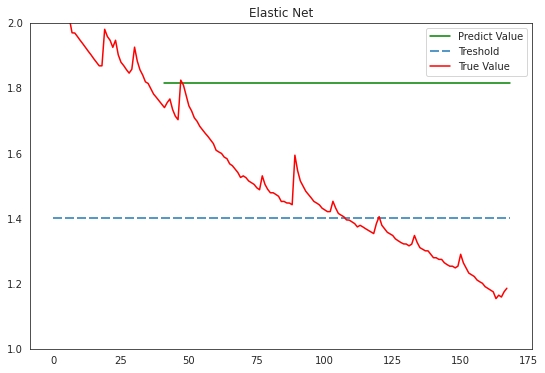

In [ ]:
# Plot the prediction vs test data
from matplotlib import pyplot
pyplot.figure(figsize=(9, 6))
pyplot.plot(test_df['Predict Value'], label="Predict Value", color='Green')
pyplot.plot([0.,168], [1.4, 1.4],dashes=[6, 2], label="Treshold")
pyplot.plot(plot_df['Capacity'], color='red', label="True Value")
plt.title('Elastic Net')
plt.ylim(1, 2)
plt.legend()

## Gradient Boosting


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor().fit(train_dataset, train_target_value)
pred = reg.predict(test_dataset)

In [ ]:
true_value = np.array(test_target_value).reshape(-1,1)
predict_value = pred.reshape(-1, 1)
print(true_value.shape)
print(predict_value.shape)
check_arr = np.concatenate([true_value, predict_value,test_cycle], axis=1)
test_df = pd.DataFrame(check_arr)
test_df.columns =['True Value','Predict Value', 'cycle']
test_df = test_df.groupby(['cycle']).mean().reset_index()
test_df=test_df.set_index('cycle')
print(test_df.tail())
rms = np.sqrt(mean_squared_error(test_df['True Value'], test_df['Predict Value']))
print('Root Mean Square Error: ',np.round(rms,5))
rms_table['Gradient Boosting'] = rms

(41031, 1)
(41031, 1)
       True Value  Predict Value
cycle                           
164.0    1.293464       1.799056
165.0    1.288003       1.799408
166.0    1.287453       1.799654
167.0    1.309015       1.802751
168.0    1.325079       1.807884
Root Mean Square Error:  0.34118


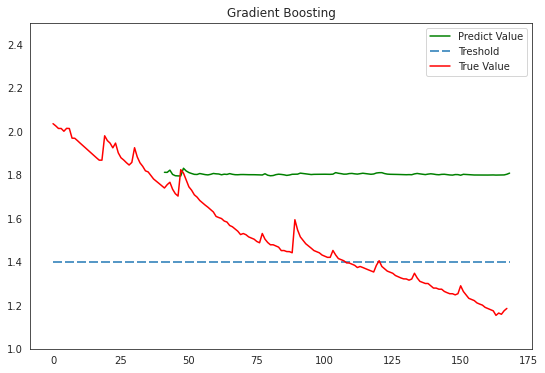

In [ ]:
# Plot the prediction vs test data
from matplotlib import pyplot
pyplot.figure(figsize=(9, 6))
pyplot.plot(test_df['Predict Value'], label="Predict Value", color='Green')
pyplot.plot([0.,168], [1.4, 1.4],dashes=[6, 2], label="Treshold")
pyplot.plot(plot_df['Capacity'], color='red', label="True Value")
plt.title('Gradient Boosting')
plt.ylim(1, 2.5)
plt.legend()

## Result

In [ ]:
rmse_table = pd.DataFrame(data=rms_table, index=[0])
rmse_table = rmse_table.T
rmse_table.columns=['RMSE']
rmse_table

,RMSE
Linear Regression,0.345874
K Nearest Neighbor,0.337173
Decision Tree,0.332167
Elastic Net,0.353231
Gradient Boosting,0.341182


# Capacity Predicition for B0005 by training all data


## Prepare data

In [ ]:
attribs=['voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load']
train_cycle = new_df['cycle'].reset_index().drop('index',axis=1)
test_cycle =  new_df[(new_df['cycle']>40)]['cycle'].reset_index().drop('index',axis=1)
train_dataset = new_df[attribs]
test_dataset = new_df.loc[(new_df['cycle']>40),attribs]
train_target_value = new_df['capacity']
test_target_value = new_df.loc[(new_df['cycle']>40),'capacity']
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
test_dataset = sc.transform(test_dataset)
rms_table={}
fail_cycle=[]
R_square=[]
print(f'Shape of train dataset: {train_dataset.shape}')
print(f'Shape of target value of dataset: {train_target_value.shape}')

Shape of train dataset: (168, 5)
Shape of target value of dataset: (168,)


## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(train_dataset, train_target_value)
pred = reg.predict(test_dataset)
print(test_dataset.shape)
pred.shape

(128, 5)


(128,)

In [ ]:
true_value = np.array(test_target_value).reshape(-1,1)
predict_value = pred.reshape(-1, 1)
print(true_value.shape)
print(predict_value.shape)
check_arr = np.concatenate([true_value, predict_value,test_cycle], axis=1)
test_df = pd.DataFrame(check_arr)
test_df.columns =['True Value','Predict Value', 'cycle']
test_df = test_df.groupby(['cycle']).mean().reset_index()
test_df=test_df.set_index('cycle')
print(test_df.head())
rms = np.sqrt(mean_squared_error(test_df['True Value'], test_df['Predict Value']))
print('Root Mean Square Error: ', np.round(rms,5))
rms_table['Linear Regression'] = rms
if len(test_df.loc[test_df['Predict Value']<=1.4].index)>0:
  fail_cycle.append(min(test_df.loc[test_df['Predict Value']<=1.4].index))
else:
  fail_cycle.append(0)
R_square.append(metrics.r2_score(true_value,predict_value))

(128, 1)
(128, 1)
       True Value  Predict Value
cycle                           
41.0     1.767872       1.780282
42.0     1.762315       1.784847
43.0     1.767617       1.814086
44.0     1.762668       1.791039
45.0     1.751730       1.774310
Root Mean Square Error:  0.01725


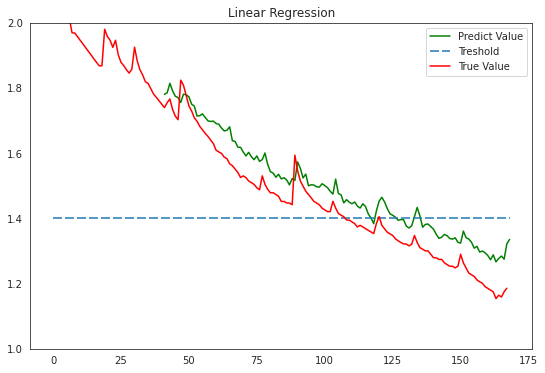

In [ ]:
# Plot the prediction vs test data
from matplotlib import pyplot
pyplot.figure(figsize=(9, 6))
pyplot.plot(test_df['Predict Value'], label="Predict Value", color='Green')
pyplot.plot([0.,168], [1.4, 1.4],dashes=[6, 2], label="Treshold")
pyplot.plot(plot_df['Capacity'], color='red', label="True Value")
plt.ylim(1, 2)
plt.title('Linear Regression')
plt.legend()

## SVR Regression

In [ ]:
from sklearn.svm import SVR
reg = SVR().fit(train_dataset, train_target_value)
pred =reg.predict(test_dataset)

In [ ]:
true_value = np.array(test_target_value).reshape(-1,1)
predict_value = pred.reshape(-1, 1)
print(true_value.shape)
print(predict_value.shape)
check_arr = np.concatenate([true_value, predict_value,test_cycle], axis=1)
test_df = pd.DataFrame(check_arr)
test_df.columns =['True Value','Predict Value', 'cycle']
test_df = test_df.groupby(['cycle']).mean().reset_index()
test_df=test_df.set_index('cycle')
print(test_df.tail())
rms = np.sqrt(mean_squared_error(test_df['True Value'], test_df['Predict Value']))
print('Root Mean Square Error: ', np.round(rms,5))
rms_table['SVR'] = rms
if len(test_df.loc[test_df['Predict Value']<=1.4].index)>0:
  fail_cycle.append(min(test_df.loc[test_df['Predict Value']<=1.4].index))
else:
  fail_cycle.append(0)
R_square.append(metrics.r2_score(true_value,predict_value))

(128, 1)
(128, 1)
       True Value  Predict Value
cycle                           
164.0    1.293464       1.389027
165.0    1.288003       1.388047
166.0    1.287453       1.387553
167.0    1.309015       1.402033
168.0    1.325079       1.415929
Root Mean Square Error:  0.07143


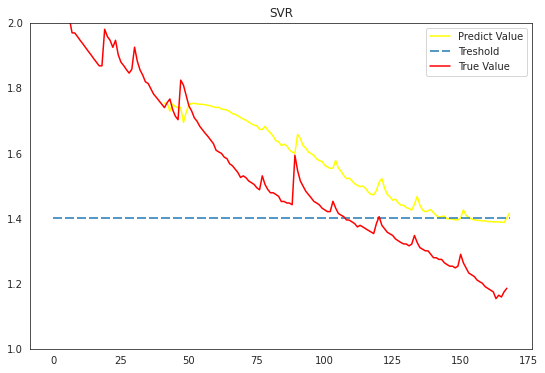

In [ ]:
from matplotlib import pyplot
pyplot.figure(figsize=(9, 6))
pyplot.plot(test_df['Predict Value'], label="Predict Value", color='Yellow')
pyplot.plot([0.,168], [1.4, 1.4],dashes=[6, 2], label="Treshold")
pyplot.plot(plot_df['Capacity'], color='red', label="True Value")
plt.title('SVR')
plt.ylim(1, 2)
plt.legend()

## K Nearest **Neighbor**

In [ ]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
reg = neighbors.KNeighborsRegressor(n_neighbors = 10).fit(train_dataset, train_target_value)
pred = reg.predict(test_dataset)

In [ ]:
true_value = np.array(test_target_value).reshape(-1,1)
predict_value = pred.reshape(-1, 1)
print(true_value.shape)
print(predict_value.shape)
check_arr = np.concatenate([true_value, predict_value,test_cycle], axis=1)
test_df = pd.DataFrame(check_arr)
test_df.columns =['True Value','Predict Value', 'cycle']
test_df = test_df.groupby(['cycle']).mean().reset_index()
test_df=test_df.set_index('cycle')
print(test_df.tail())
rms = np.sqrt(mean_squared_error(test_df['True Value'], test_df['Predict Value']))
print('Root Mean Square Error: ', np.round(rms,5))
rms_table['K Nearest Neighbor'] = rms
if len(test_df.loc[test_df['Predict Value']<=1.4].index)>0:
  fail_cycle.append(min(test_df.loc[test_df['Predict Value']<=1.4].index))
else:
  fail_cycle.append(0)
R_square.append(metrics.r2_score(true_value,predict_value))

(128, 1)
(128, 1)
       True Value  Predict Value
cycle                           
164.0    1.293464       1.299568
165.0    1.288003       1.299595
166.0    1.287453       1.299568
167.0    1.309015       1.330545
168.0    1.325079       1.343984
Root Mean Square Error:  0.01196


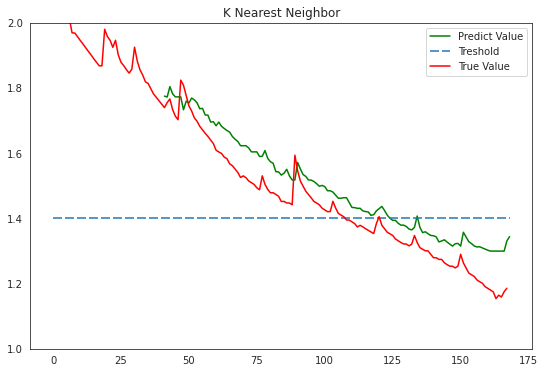

In [ ]:
# Plot the prediction vs test data
from matplotlib import pyplot
pyplot.figure(figsize=(9, 6))
pyplot.plot(test_df['Predict Value'], label="Predict Value", color='Green')
pyplot.plot([0.,168], [1.4, 1.4],dashes=[6, 2], label="Treshold")
pyplot.plot(plot_df['Capacity'], color='red', label="True Value")
plt.title('K Nearest Neighbor')
plt.ylim(1, 2)
plt.legend()

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor().fit(train_dataset, train_target_value)
pred = reg.predict(test_dataset)

In [ ]:
true_value = np.array(test_target_value).reshape(-1,1)
predict_value = pred.reshape(-1, 1)
print(true_value.shape)
print(predict_value.shape)
check_arr = np.concatenate([true_value, predict_value,test_cycle], axis=1)
test_df = pd.DataFrame(check_arr)
test_df.columns =['True Value','Predict Value', 'cycle']
test_df = test_df.groupby(['cycle']).mean().reset_index()
test_df=test_df.set_index('cycle')
print(test_df.tail())
rms = np.sqrt(mean_squared_error(test_df['True Value'], test_df['Predict Value']))
print('Root Mean Square Error: ',np.round(rms,5))
rms_table['Decision Tree'] = rms
if len(test_df.loc[test_df['Predict Value']<=1.4].index)>0:
  fail_cycle.append(min(test_df.loc[test_df['Predict Value']<=1.4].index))
else:
  fail_cycle.append(0)
R_square.append(metrics.r2_score(true_value,predict_value))

(128, 1)
(128, 1)
       True Value  Predict Value
cycle                           
164.0    1.293464       1.293464
165.0    1.288003       1.287728
166.0    1.287453       1.287728
167.0    1.309015       1.309015
168.0    1.325079       1.325079
Root Mean Square Error:  0.00013


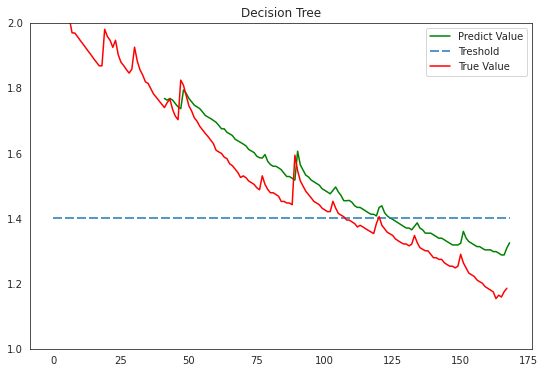

In [ ]:
# Plot the prediction vs test data
from matplotlib import pyplot
pyplot.figure(figsize=(9, 6))
pyplot.plot(test_df['Predict Value'], label="Predict Value", color='Green')
pyplot.plot([0.,168], [1.4, 1.4],dashes=[6, 2], label="Treshold")
pyplot.plot(plot_df['Capacity'], color='red', label="True Value")
plt.title('Decision Tree')
plt.ylim(1, 2)
plt.legend()

## ElasticNet 

In [ ]:
from sklearn.linear_model import ElasticNet
reg = ElasticNet().fit(train_dataset, train_target_value)
pred = reg.predict(test_dataset)

In [ ]:
true_value = np.array(test_target_value).reshape(-1,1)
predict_value = pred.reshape(-1, 1)
print(true_value.shape)
print(predict_value.shape)
check_arr = np.concatenate([true_value, predict_value,test_cycle], axis=1)
test_df = pd.DataFrame(check_arr)
test_df.columns =['True Value','Predict Value', 'cycle']
test_df = test_df.groupby(['cycle']).mean().reset_index()
test_df=test_df.set_index('cycle')
print(test_df.tail())
rms = np.sqrt(mean_squared_error(test_df['True Value'], test_df['Predict Value']))
print('Root Mean Square Error: ',np.round(rms,5))
rms_table['Elastic Net'] = rms
if len(test_df.loc[test_df['Predict Value']<=1.4].index)>0:
  fail_cycle.append(min(test_df.loc[test_df['Predict Value']<=1.4].index))
else:
  fail_cycle.append(0)
R_square.append(metrics.r2_score(true_value,predict_value))

(128, 1)
(128, 1)
       True Value  Predict Value
cycle                           
164.0    1.293464       1.572502
165.0    1.288003       1.572502
166.0    1.287453       1.572502
167.0    1.309015       1.572502
168.0    1.325079       1.572502
Root Mean Square Error:  0.16833


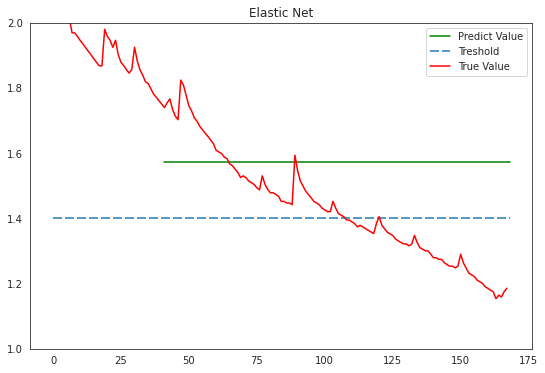

In [ ]:
# Plot the prediction vs test data
from matplotlib import pyplot
pyplot.figure(figsize=(9, 6))
pyplot.plot(test_df['Predict Value'], label="Predict Value", color='Green')
pyplot.plot([0.,168], [1.4, 1.4],dashes=[6, 2], label="Treshold")
pyplot.plot(plot_df['Capacity'], color='red', label="True Value")
plt.title('Elastic Net')
plt.ylim(1, 2)
plt.legend()

## Gradient Boosting


In [ ]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
reg = ensemble.GradientBoostingRegressor(**params).fit(train_dataset, train_target_value)
pred = reg.predict(test_dataset)

In [ ]:
true_value = np.array(test_target_value).reshape(-1,1)
predict_value = pred.reshape(-1, 1)
print(true_value.shape)
print(predict_value.shape)
check_arr = np.concatenate([true_value, predict_value,test_cycle], axis=1)
test_df = pd.DataFrame(check_arr)
test_df.columns =['True Value','Predict Value', 'cycle']
test_df = test_df.groupby(['cycle']).mean().reset_index()
test_df=test_df.set_index('cycle')
print(test_df.tail())
rms = np.sqrt(mean_squared_error(test_df['True Value'], test_df['Predict Value']))
print('Root Mean Square Error: ',np.round(rms,5))
rms_table['Gradient Boosting'] = rms
if len(test_df.loc[test_df['Predict Value']<=1.4].index)>0:
  fail_cycle.append(min(test_df.loc[test_df['Predict Value']<=1.4].index))
else:
  fail_cycle.append(0)
R_square.append(metrics.r2_score(true_value,predict_value))

(128, 1)
(128, 1)
       True Value  Predict Value
cycle                           
164.0    1.293464       1.296121
165.0    1.288003       1.290991
166.0    1.287453       1.290968
167.0    1.309015       1.314338
168.0    1.325079       1.330027
Root Mean Square Error:  0.00259


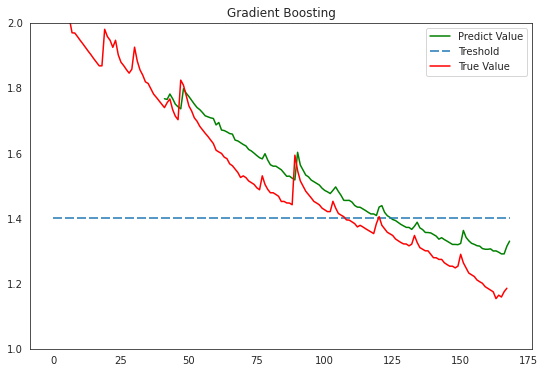

In [ ]:
# Plot the prediction vs test data
from matplotlib import pyplot
pyplot.figure(figsize=(9, 6))
pyplot.plot(test_df['Predict Value'], label="Predict Value", color='Green')
pyplot.plot([0.,168], [1.4, 1.4],dashes=[6, 2], label="Treshold")
pyplot.plot(plot_df['Capacity'], color='red', label="True Value")
plt.title('Gradient Boosting')
plt.ylim(1, 2)
plt.legend()

## Result

In [ ]:
rmse_table = pd.DataFrame(data=rms_table, index=[0])
rmse_table = rmse_table.T
rmse_table.columns=['RMSE']
rmse_table['Fail Cycle'] = fail_cycle
rmse_table['Error'] = rmse_table['Fail Cycle'] - 128
rmse_table['R_Square'] = R_square
rmse_table

,RMSE,Fail Cycle,Error,R_Square
Linear Regression,0.017246,118.0,-10.0,0.986748
SVR,0.071428,145.0,17.0,0.772684
K Nearest Neighbor,0.011955,125.0,-3.0,0.993632
Decision Tree,0.000131,125.0,-3.0,0.999999
Elastic Net,0.168327,0.0,-128.0,-0.262392
Gradient Boosting,0.002588,125.0,-3.0,0.999702


# RUL estimation
In the same way that was done for the estimation of SoH, the training and testing dataset is prepared, in this particular case the battery capacity data is used using the first data of the first 50 cycles to predict the capacity in the following cycles in such a way as to be able to know when the threshold of the battery is reached and estimate the remaining cycles to reach the End of Life of the battery

In [ ]:
dataset_val, capacity_val = load_data('B0005')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
rows=['cycle','capacity']
dataset=dis_ele[rows]
data_train=dataset[(dataset['cycle']<50)]
data_set_train=data_train.iloc[:,1:2].values
data_test=dataset[(dataset['cycle']>=50)]
data_set_test=data_test.iloc[:,1:2].values

sc=MinMaxScaler(feature_range=(0,1))
data_set_train=sc.fit_transform(data_set_train)
data_set_test=sc.transform(data_set_test)

X_train=[]
y_train=[]
#take the last 10t to predict 10t+1
for i in range(10,49):
    X_train.append(data_set_train[i-10:i,0])
    y_train.append(data_set_train[i,0])
X_train,y_train=np.array(X_train),np.array(y_train)
df_train=pd.DataFrame(X_train)
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]


In [ ]:
#pd.set_option("display.max_columns", None)
#df_train['Y']=y_train
#df_train

In this section the model is trained, based on the proposal of [2] and making use of LSTM-type networks instead of standard neural networks.

In [ ]:
regress = Sequential()
regress.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1],1)))
regress.add(Dropout(0.3))
regress.add(LSTM(units=200, return_sequences=True))
regress.add(Dropout(0.3))
regress.add(LSTM(units=200, return_sequences=True))
regress.add(Dropout(0.3))
regress.add(LSTM(units=200))
regress.add(Dropout(0.3))
regress.add(Dense(units=1))
regress.compile(optimizer='adam',loss='mean_squared_error')
regress.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 200)           161600    
                                                                 
 dropout_1 (Dropout)         (None, 10, 200)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 200)           320800    
                                                                 
 dropout_2 (Dropout)         (None, 10, 200)           0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 200)           320800    
                                                                 
 dropout_3 (Dropout)         (None, 10, 200)           0         
                                                                 
 lstm_3 (LSTM)               (None, 200)              

In [ ]:
regress.fit(X_train,y_train,epochs=200,batch_size=25)

Epoch 1/200
2/2 [==============================] - 7s 101ms/step - loss: 0.3105
Epoch 2/200
2/2 [==============================] - 0s 83ms/step - loss: 0.1122
Epoch 3/200
2/2 [==============================] - 0s 88ms/step - loss: 0.1198
Epoch 4/200
2/2 [==============================] - 0s 86ms/step - loss: 0.0501
Epoch 5/200
2/2 [==============================] - 0s 83ms/step - loss: 0.0908
Epoch 6/200
2/2 [==============================] - 0s 80ms/step - loss: 0.0740
Epoch 7/200
2/2 [==============================] - 0s 88ms/step - loss: 0.0499
Epoch 8/200
2/2 [==============================] - 0s 82ms/step - loss: 0.0500
Epoch 9/200
2/2 [==============================] - 0s 81ms/step - loss: 0.0555
Epoch 10/200
2/2 [==============================] - 0s 81ms/step - loss: 0.0478
Epoch 11/200
2/2 [==============================] - 0s 81ms/step - loss: 0.0535
Epoch 12/200
2/2 [==============================] - 0s 85ms/step - loss: 0.0535
Epoch 13/200
2/2 [==============================

In [ ]:
print(len(data_test))
data_total=pd.concat((data_train['capacity'], data_test['capacity']),axis=0)
inputs=data_total[len(data_total)-len(data_test)-10:].values
inputs=inputs.reshape(-1,1)
inputs=sc.transform(inputs)

119


In [ ]:
X_test=[]
for i in range(10,129):
    X_test.append(inputs[i-10:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
pred=regress.predict(X_test)
print(pred.shape)
pred=sc.inverse_transform(pred)
pred=pred[:,0]
tests=data_test.iloc[:,1:2]
rmse = np.sqrt(mean_squared_error(tests, pred))
print('Test RMSE: %.3f' % rmse)
metrics.r2_score(tests,pred)

(119, 1)
Test RMSE: 0.066


0.760761606077841

As can be seen, the mean RMSE is 0.05 (5%), which is very close to the values observed in the literature using this type of network.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Discharge B0005 (prediction) start in cycle 50 -RULe=-8, window-size=10')

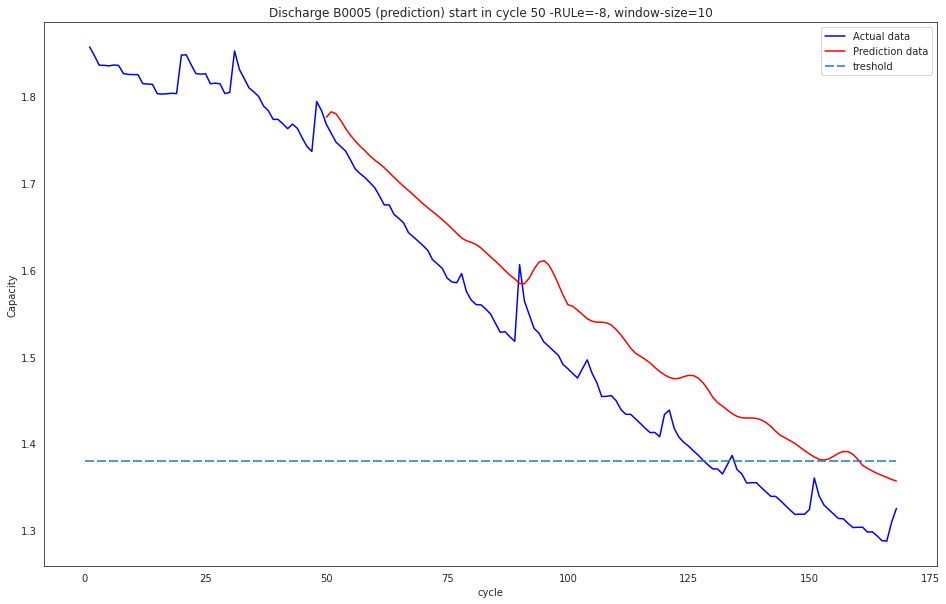

In [ ]:
ln = len(data_train)
data_test['pre']=pred
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_per = data_test.loc[(data_test['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['pre'],label="Prediction data", color='red')
#Draw threshold
plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="treshold")
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 (prediction) start in cycle 50 -RULe=-8, window-size=10')

Finally, it can be seen in the graph that the capacity value and how it behaves over time is very close to the real value and supporting these data, the error in the estimation of the RUL was -8 which makes us understand that The model went ahead by 8 cycles to estimate that the battery reached its end of life.

In [ ]:
pred=0
Afil=0
Pfil=0
a=data_test['capacity'].values
b=data_test['pre'].values
j=0
k=0
for i in range(len(a)):
    actual=a[i]
    
    if actual<=1.38:
        j=i
        Afil=j
        break
for i in range(len(a)):
    pred=b[i]
    if pred< 1.38:
        k=i
        Pfil=k
        break
print("The Actual fail at cycle number: "+ str(Afil+ln))
print("The prediction fail at cycle number: "+ str(Pfil+ln))
RULerror=Pfil-Afil
print("The error of RUL= "+ str(RULerror)+ " Cycle(s)")

The Actual fail at cycle number: 128
The prediction fail at cycle number: 160
The error of RUL= 32 Cycle(s)


# RUL Estimation with AR Model

In [ ]:
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [ ]:
data = dataset[['cycle','capacity']]
train_data = data['capacity'][:80]
test_data = data['capacity'][80:]
print(test_data)

80     1.559766
81     1.559482
82     1.554689
83     1.548874
84     1.538237
         ...   
163    1.293464
164    1.288003
165    1.287453
166    1.309015
167    1.325079
Name: capacity, Length: 88, dtype: float64


In [ ]:
train_data2 = data['capacity'][:40]
test_data2 = data['capacity'][40:]

In [ ]:
train_data3 = data['capacity'][:60]
test_data3 = data['capacity'][60:]

In [ ]:
len(test_data2)

128

## Select best parameters for AR model



In [ ]:
sel = ar_select_order(data['capacity'],maxlag=20,ic='aic')
sel.ar_lags
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               capacity   No. Observations:                  168
Model:                     AutoReg(4)   Log Likelihood                 483.410
Method:               Conditional MLE   S.D. of innovations              0.013
Date:                Sun, 14 Nov 2021   AIC                           -954.821
Time:                        07:47:31   BIC                           -936.222
Sample:                             4   HQIC                          -947.270
                                  168                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0003      0.008     -0.037      0.971      -0.017       0.016
capacity.L1     0.8672      0.078     11.063      0.000       0.714       1.021
capacity.L2    -0.0388      0.103     -0.375    

In [ ]:
sel = ar_select_order(train_data,maxlag=10,ic='aic')
sel.ar_lags
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               capacity   No. Observations:                   80
Model:                     AutoReg(1)   Log Likelihood                 237.687
Method:               Conditional MLE   S.D. of innovations              0.012
Date:                Sun, 14 Nov 2021   AIC                           -469.374
Time:                        07:47:32   BIC                           -462.265
Sample:                             1   HQIC                          -466.526
                                   80                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0247      0.029     -0.850      0.396      -0.082       0.032
capacity.L1     1.0120      0.017     61.211      0.000       0.980       1.044
                                    Roots       

In [ ]:
sel = ar_select_order(train_data2,maxlag=10,ic='aic')
sel.ar_lags
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               capacity   No. Observations:                   40
Model:                     AutoReg(1)   Log Likelihood                 117.485
Method:               Conditional MLE   S.D. of innovations              0.012
Date:                Sun, 14 Nov 2021   AIC                           -228.970
Time:                        07:47:32   BIC                           -223.979
Sample:                             1   HQIC                          -227.179
                                   40                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3592      0.184      1.953      0.051      -0.001       0.720
capacity.L1     0.8014      0.101      7.926      0.000       0.603       1.000
                                    Roots       

In [ ]:
sel = ar_select_order(train_data3,maxlag=10,ic='aic')
sel.ar_lags
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               capacity   No. Observations:                   60
Model:                     AutoReg(1)   Log Likelihood                 171.361
Method:               Conditional MLE   S.D. of innovations              0.013
Date:                Sun, 14 Nov 2021   AIC                           -336.721
Time:                        07:47:32   BIC                           -330.489
Sample:                             1   HQIC                          -334.288
                                   60                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0407      0.077      0.527      0.598      -0.111       0.192
capacity.L1     0.9758      0.043     22.681      0.000       0.891       1.060
                                    Roots       

## Train model base on the params get from above


In [ ]:
ar_model = AutoReg(train_data, lags=1).fit()
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:               capacity   No. Observations:                   80
Model:                     AutoReg(1)   Log Likelihood                 237.687
Method:               Conditional MLE   S.D. of innovations              0.012
Date:                Sun, 14 Nov 2021   AIC                           -469.374
Time:                        07:47:32   BIC                           -462.265
Sample:                             1   HQIC                          -466.526
                                   80                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0247      0.029     -0.850      0.396      -0.082       0.032
capacity.L1     1.0120      0.017     61.211      0.000       0.980       1.044
                                    Roots       

In [ ]:
ar_model2 = AutoReg(train_data2, lags=1).fit()
print(ar_model2.summary())

                            AutoReg Model Results                             
Dep. Variable:               capacity   No. Observations:                   40
Model:                     AutoReg(1)   Log Likelihood                 117.485
Method:               Conditional MLE   S.D. of innovations              0.012
Date:                Sun, 14 Nov 2021   AIC                           -228.970
Time:                        07:47:32   BIC                           -223.979
Sample:                             1   HQIC                          -227.179
                                   40                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3592      0.184      1.953      0.051      -0.001       0.720
capacity.L1     0.8014      0.101      7.926      0.000       0.603       1.000
                                    Roots       

In [ ]:
ar_model3 = AutoReg(train_data3, lags=3).fit()
print(ar_model3.summary())

                            AutoReg Model Results                             
Dep. Variable:               capacity   No. Observations:                   60
Model:                     AutoReg(3)   Log Likelihood                 166.042
Method:               Conditional MLE   S.D. of innovations              0.013
Date:                Sun, 14 Nov 2021   AIC                           -322.083
Time:                        07:47:32   BIC                           -311.868
Sample:                             3   HQIC                          -318.113
                                   60                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0154      0.085     -0.180      0.857      -0.183       0.152
capacity.L1     0.9426      0.130      7.277      0.000       0.689       1.196
capacity.L2    -0.1422      0.179     -0.796    

In [ ]:
# Make the predictions
pred = ar_model.predict(start=80, end=(len(data)-1))
pred2= ar_model2.predict(start=40, end=(len(data)-1))
pred3= ar_model3.predict(start=60, end=(len(data)-1))

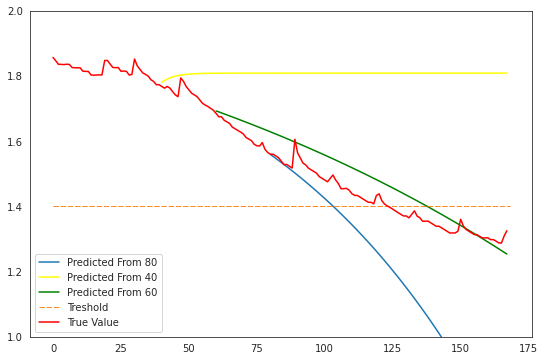

In [ ]:
# Plot the prediction vs test data
#
from matplotlib import pyplot
pyplot.figure(figsize=(9, 6))
pyplot.plot(pred, label="Predicted From 80")
pyplot.plot(pred2, label="Predicted From 40",color='yellow')
pyplot.plot(pred3, label="Predicted From 60",color='green')
pyplot.plot([0.,168], [1.4, 1.4],dashes=[6, 2], label="Treshold",lw=0.9)
pyplot.plot(data['capacity'], color='red', label="True Value")
plt.ylim(1, 2)
plt.legend()

## Train model from all data for lags=4 + plot

In [ ]:
# 40 data train set
train_data = data['capacity'][:40]
test_data = data['capacity'][40:]
# 60 data train set
train_data2 = data['capacity'][:60]
test_data2 = data['capacity'][60:]
# 80 data train set
train_data3 = data['capacity'][:80]
test_data3 = data['capacity'][80:]

In [ ]:
sel = ar_select_order(data['capacity'],maxlag=20,ic='aic')
sel.ar_lags
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               capacity   No. Observations:                  168
Model:                     AutoReg(4)   Log Likelihood                 483.410
Method:               Conditional MLE   S.D. of innovations              0.013
Date:                Sun, 14 Nov 2021   AIC                           -954.821
Time:                        07:47:32   BIC                           -936.222
Sample:                             4   HQIC                          -947.270
                                  168                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0003      0.008     -0.037      0.971      -0.017       0.016
capacity.L1     0.8672      0.078     11.063      0.000       0.714       1.021
capacity.L2    -0.0388      0.103     -0.375    

In [ ]:
ar_model_full = AutoReg(data['capacity'], lags=4).fit()
ar_model = AutoReg(train_data, lags=4).fit()
ar_model2 = AutoReg(train_data2, lags=4).fit()
ar_model3 = AutoReg(train_data3, lags=4).fit()

In [ ]:
# Make the predictions
pred_full = ar_model_full.predict(start=50, end=(len(data)-1))
pred = ar_model.predict(start=40, end=(len(data)-1))
pred2= ar_model2.predict(start=60, end=(len(data)-1))
pred3= ar_model3.predict(start=80, end=(len(data)-1))

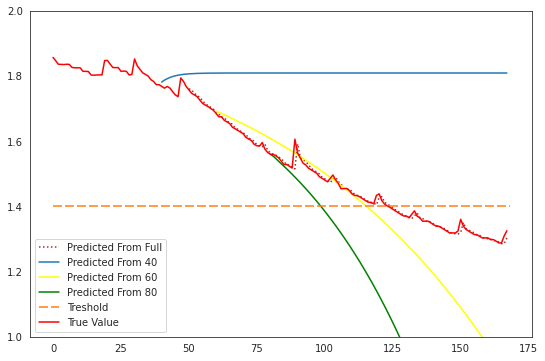

In [ ]:
# Plot the prediction vs test data
#
from matplotlib import pyplot
pyplot.figure(figsize=(9, 6))
pyplot.plot(pred_full, label="Predicted From Full", color='brown',ls=":" )
pyplot.plot(pred, label="Predicted From 40")
pyplot.plot(pred2, label="Predicted From 60",color='yellow')
pyplot.plot(pred3, label="Predicted From 80",color='green')
pyplot.plot([0.,168], [1.4, 1.4],dashes=[6, 2], label="Treshold")
pyplot.plot(data['capacity'], color='red', label="True Value")
plt.ylim(1, 2)
plt.legend()

In [ ]:
AR, P, k = aryule(data['capacity'],4)
print(AR)
print(P)
print(k)

[-0.98905447  0.00194635 -0.00970888  0.00297042]
0.03104294303041135
[-0.99379346 -0.00475642 -0.00677104  0.00297042]


# Conclusion 
For SOH, I only use neural network with 3 layers and dropout to train the model <br>
For RUL, I apply time series forcasting with stacked LSTM model: <br>
<tab>- Time-series forcasting with time steps of 10 for the capacity of the battery <br>
<tab>- LSTM model with 4 layers and 200 units each layers then dropout with chance of 30%<br>
RUL Estimation Model recieve R-Square~ 0.81 indicate that our prediction is 81% match the expectation and RMSE:0.059 means that we might have about 0.059 of deviation from the true value in our prediction.<br>
Base on the graph, I can also said that the predictions is higher than true value most of the time. Thus, there should be some kind of regulation for the model since it always predict higher.